In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 66kB/s 
     |████████████████████████████████| 501kB 45.3MB/s 
     |████████████████████████████████| 3.1MB 32.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.0.0-beta1'

In [4]:
print("GPU Available: ", tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
device_name

GPU Available:  True


'/device:GPU:0'

In [0]:
def make_dcgan_generator(z_size=20, output_size=(28, 28, 1),
                         n_filters=128, n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (output_size[0]//size_factor, 
                   output_size[1]//size_factor)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(tf.keras.layers.Conv2DTranspose(
            filters=nf, kernel_size=(5, 5), strides=(2, 2),
            padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
        
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=output_size[2], kernel_size=(5, 5), strides=(1, 1), 
        padding='same', use_bias=False, activation='tanh'))
        
    return model

def make_dcgan_discriminator(input_size=(28, 28, 1),
                             n_filters=64, n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(tf.keras.layers.Conv2D(
            filters=nf, kernel_size=(5, 5), 
            strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model


In [6]:
gen_model = make_dcgan_generator()
gen_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              125440    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [7]:
disc_model = make_dcgan_discriminator()
disc_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)      

In [8]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
      input_z = tf.random.uniform(shape=(z_size,),
                                  minval=-1.0, maxval=1.0)
    elif mode == 'normal':
      input_z = tf.random.normal(shape=(z_size,))
    return input_z, image


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

W0828 00:26:46.774342 139642776811392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


In [9]:
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gamma_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device('/device:GPU:0'):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()


W0828 00:27:21.557843 139642776811392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_7 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [10]:
import time

## optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = (d_loss_real + d_loss_fake) #0.5*
        
            ## Compute generator's loss and gradients:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Gradeint-penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (alpha * input_real + 
                                (1 - alpha) * g_output.numpy())
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads_intp), 
                                                 axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + gamma_gp*grad_penalty
            
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))

        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(create_samples(
          gen_model, fixed_z).numpy())


Epoch   1 | ET 5.31 min | Avg Losses >> G/D 176.31/-211.92 [D-Real: -160.62 D-Fake: -176.31]
Epoch   2 | ET 10.57 min | Avg Losses >> G/D  84.07/-21.88 [D-Real: -19.45 D-Fake: -84.07]
Epoch   3 | ET 15.84 min | Avg Losses >> G/D  64.12/-30.69 [D-Real:   7.94 D-Fake: -64.12]
Epoch   4 | ET 21.11 min | Avg Losses >> G/D  67.68/-36.47 [D-Real:   9.82 D-Fake: -67.68]
Epoch   5 | ET 26.37 min | Avg Losses >> G/D  54.51/-33.89 [D-Real:  10.90 D-Fake: -54.51]
Epoch   6 | ET 31.64 min | Avg Losses >> G/D  61.49/-32.20 [D-Real:  15.38 D-Fake: -61.49]
Epoch   7 | ET 36.90 min | Avg Losses >> G/D  69.34/-33.91 [D-Real:  26.36 D-Fake: -69.34]
Epoch   8 | ET 42.10 min | Avg Losses >> G/D  79.98/-41.69 [D-Real:  23.97 D-Fake: -79.98]
Epoch   9 | ET 47.31 min | Avg Losses >> G/D  87.64/-39.20 [D-Real:  37.67 D-Fake: -87.64]
Epoch  10 | ET 52.50 min | Avg Losses >> G/D  94.40/-24.50 [D-Real:  46.76 D-Fake: -94.40]
Epoch  11 | ET 57.68 min | Avg Losses >> G/D  73.22/-20.35 [D-Real:  38.93 D-Fake: -73.2

In [0]:
import pickle
pickle.dump({'all_losses':all_losses, 
             'samples':epoch_samples}, 
            open('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-learning.pkl', 'wb'))

gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-gan_gen.h5')
disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-WDCGAN-gan_disc.h5')

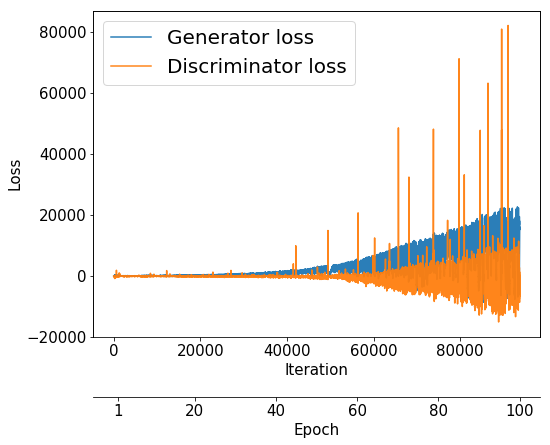

In [12]:
import itertools


fig = plt.figure(figsize=(8, 6))

## Plotting the losses
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-wdcgan-learning-curve.pdf')
plt.show()


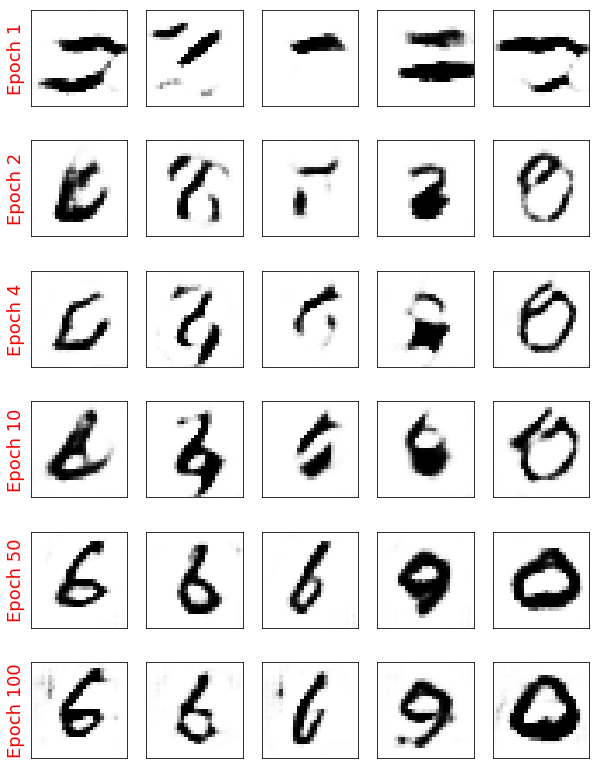

In [13]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(-0.06, 0.5, 'Epoch {}'.format(e),
                    rotation=90, size=18, color='red',
                    horizontalalignment='right',
                    verticalalignment='center', 
                    transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.savefig('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-wdcgan-samples.pdf')
plt.show()


In [0]:
import time

num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
gamma_gp = 10.0
clamp_val = 0.01

tf.random.set_seed(1)        


## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

input_z, input_real = next(iter(mnist_trainset))
print('Verify the shape --> ', input_z.shape, input_real.shape)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device('/device:GPU:0'):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

## Loss function and optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

losses = []
avg_d_vals = []
epoch_samples = {}
start_time = time.time()

for epoch in range(1, num_epochs+1):
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = (d_loss_real + d_loss_fake) #0.5*
                        
        
            ## Compute generator's loss and gradients:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Gradeint-penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = alpha * input_real + (1 - alpha) * g_output.numpy()
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads_intp), 
                                                 axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
            #print(grads_intp.shape, grads_intp_l2.shape, grad_penalty.shape)
        
            d_loss = d_loss + gamma_gp*grad_penalty
        
            
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))

        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        losses.append(
            (g_loss.numpy(), d_loss.numpy(), d_loss_real.numpy(), d_loss_fake.numpy()))
        avg_d_real = tf.reduce_mean(d_critics_real)
        avg_d_fake = tf.reduce_mean(d_critics_fake)
        avg_d_vals.append((avg_d_real.numpy(), avg_d_fake.numpy()))

                    
    #avg_epoch_losses.append(np.mean(losses, axis=0))
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(losses[-1])))
    
    epoch_samples[epoch] = view_samples(gen_model, 
                                        num_samples=8,
                                        mode=mode_z).numpy()

Verify the shape -->  (20,) (28, 28, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_42 (Batc (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_43 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4

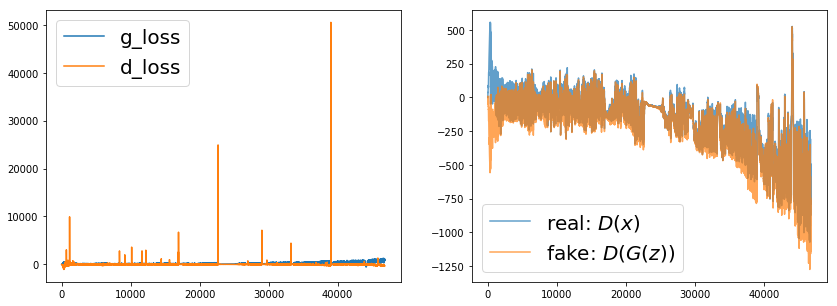

In [0]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
avg_epoch_losses = np.array(losses)
plt.plot(avg_epoch_losses[:, 0], label='g_loss')
plt.plot(avg_epoch_losses[:, 1], label='d_loss')
plt.legend(fontsize=20)

ax = fig.add_subplot(1, 2, 2)
avg_d_vals = np.array(avg_d_vals)
plt.plot(avg_d_vals[:, 0], alpha=0.7, label=r'real: $D(x)$')
plt.plot(avg_d_vals[:, 1], alpha=0.7, label=r'fake: $D(G(z))$')
plt.legend(fontsize=20)
plt.show()




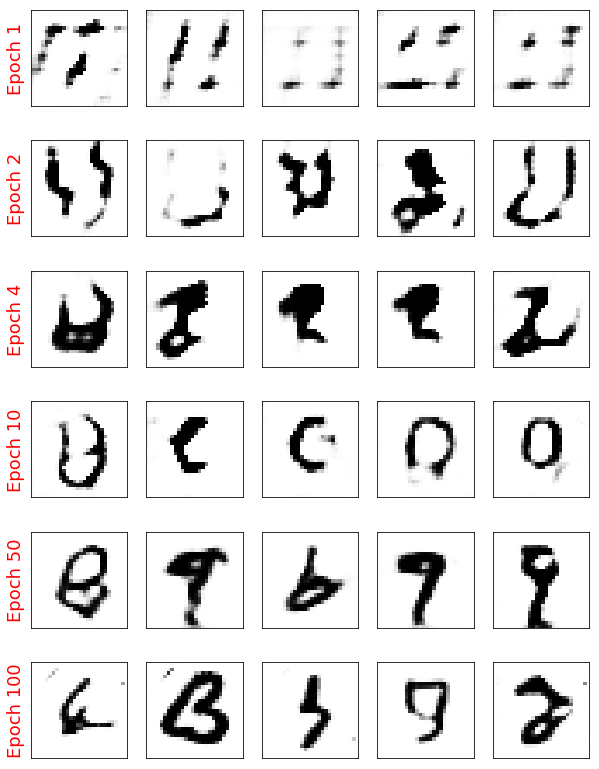

In [0]:
key_epoques = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i in range(0, 6):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        #key = i*20 if i!=0 else 1
        key = key_epoques[i]
        if j == 0:
            ax.text(-0.06, 0.5, 'Epoch {}'.format(key),
                    rotation=90, size=18, color='red',
                    horizontalalignment='right',
                    verticalalignment='center', 
                    transform=ax.transAxes)
        
        image = epoch_samples[key][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()





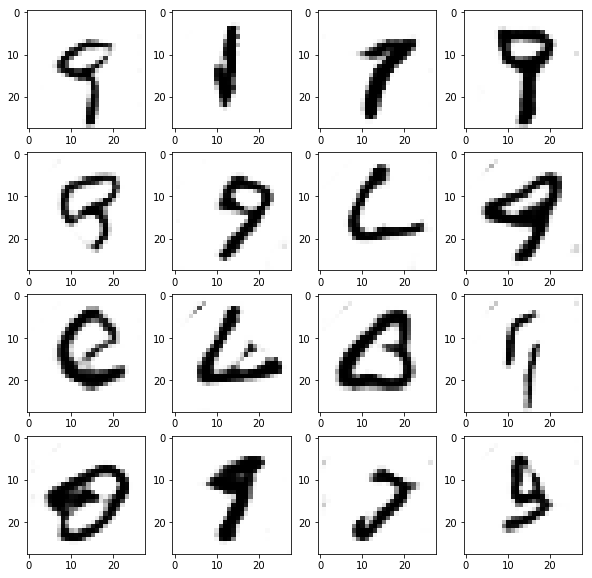

In [0]:
samples = view_samples(gen_model, 16, mode=mode_z)

fig = plt.figure(figsize=(10, 10))
for i,image in enumerate(samples):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(image, cmap='gray_r')
    
plt.show()

In [0]:
! mkdir models/
gen_model.save('models/w-dcgan_GradClip-BN-Unif_gen-model_mnist.h5')
disc_model.save('models/w-dcgan_GradClip-BN-Unif_disc-model_mnist.h5')